---
title: "Unit 2: Exploring EMIT data"
---

:::{tip}
This unit is based on the tutorial available [here](https://earth.jpl.nasa.gov/emit/data/trainings/)
:::

## EMIT data

EMIT is a NASA  imaging spectrometer installed on the International Space Station (ISS). EMIT measures radiance between 380 and 2500 nanometers, with an approximate 7 nm bandpass. Data are collected in a swath that is approximately 75 km wide at the equator, with an approximate ground sampling distance of 60 m. 

EMIT is an useful tool for mapping out greenhouse gases, including methane, carbon dioxide, and water vapor. 

The Level 2A data product contains estimated surface reflectance, uncertainty, and mask data. In addition, the geolocation of all pixel centers is included as well as the calculation of observation geometry and illumination angles on a pixel-by-pixel basis.

## Run me first

First of all, run the following cell to initialize the API.

In [145]:
import ee

# Trigger the authentication flow.
ee.Authenticate(auth_mode='localhost')

# Initialize the library.
ee.Initialize(project='ee-ializarazos')

In [146]:
import geemap
geemap.ee_initialize() 
from geemap import cartoee
import matplotlib.pyplot as plt

In [147]:
import ipyleaflet  # an interactive mapping "widget" for the notebook
from ipyleaflet import Map, TileLayer, Marker

## Getting started with EMIT data

See https://lpdaac.usgs.gov/documents/1571/EMITL2A_ATBD_v1.pdf 



In [148]:
#  Location of interest
# Cienaga Grande de Santa Marta
pt_ag = ee.Geometry.Point([-74.3822, 10.8689])

In [149]:
# Initial date of interest (inclusive).
start_date = '2025-01-01'

# Final date of interest (exclusive).
end_date = '2025-12-31'

In [150]:
# Import the intented Image Collection.
# We will use EMIT Surface Reflectance Product
emit = ee.ImageCollection("NASA/EMIT/L2A/RFL").filterDate(start_date , end_date).filterBounds(pt_ag);


In [151]:
print(emit)  #Explore data structure 

ee.ImageCollection({
  "functionInvocationValue": {
    "functionName": "Collection.filter",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.filter",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "ImageCollection.load",
                "arguments": {
                  "id": {
                    "constantValue": "NASA/EMIT/L2A/RFL"
                  }
                }
              }
            },
            "filter": {
              "functionInvocationValue": {
                "functionName": "Filter.dateRangeContains",
                "arguments": {
                  "leftValue": {
                    "functionInvocationValue": {
                      "functionName": "DateRange",
                      "arguments": {
                        "end": {
                          "constantValue": "2025-12-31"
                        },
   

In [152]:
## Select image and bands of interest

In [153]:
img = emit.first()
img = img.select(ee.List.sequence(0, 578))
img = img.set('system:time_start', img.get('system:time_start'))
                

In [154]:
##print(img.bandNames())

## Let's plot the EMIT Image

### Using ipyleaflet

In [155]:
dir(ipyleaflet.basemaps.OpenStreetMap)

['BZH', 'CAT', 'CH', 'DE', 'France', 'HOT', 'Mapnik']

In [156]:
map = ipyleaflet.Map(
    center=(10.8689, -74.3822), zoom=9 ,
    layout={'height':'200px'},
    basemap=ipyleaflet.basemaps.OpenStreetMap.Mapnik
)

First we start by defining a function that takes an Earth Engine image object, and generates a tile layer URL that ipyleaflet can utilize.

In [157]:
def image_to_tile_url(image, vis_params=None):
    """
    Given an ee.Image, return an XYZ tile URL for ipyleaflet.

    Parameters
    ----------
    image : ee.Image
        Earth Engine image to visualize.
    vis_params : dict, optional
        Visualization parameters (min, max, bands, palette, etc.).

    Returns
    -------
    str
        URL template like:
        'https://earthengine.googleapis.com/.../tiles/{z}/{x}/{y}'
    """
    if vis_params is None:
        vis_params = {}

    # map_id is a dict with 'tile_fetcher'
    map_id = image.getMapId(vis_params)
    tile_url = map_id["tile_fetcher"].url_format
    return tile_url

In [158]:
vis = {"min": 0.01, "max": 0.30, 
       "bands": ["reflectance_34", "reflectance_20", "reflectance_10"]}

In [159]:
url = image_to_tile_url(img, vis)

In [160]:
map.add_layer(TileLayer(url=url, name='EMIT True Color'))
# Adding the layers control to the map.
map.add_control(ipyleaflet.LayersControl())
map

Map(center=[10.8689, -74.3822], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

### Using cartoee

In [161]:
fig = plt.figure(figsize=(15, 10))

# use cartoee to get a map
ax = cartoee.get_map(img, vis_params=true_emit)

# pad the view for some visual appeal
cartoee.pad_view(ax)

# add the gridlines and specify that the xtick labels be rotated 45 degrees
cartoee.add_gridlines(ax, interval=0.5, xtick_rotation=45, linestyle=":")

# add the coastline
#ax.coastlines(color="yellow")

plt.show()

In [162]:
# Save the map as a standalone HTML file
#Map.save('emit_u2.html')
#html_file = 'emit_u2.html'
#Map.to_html(filename=html_file, title="EMIT composition", width="100%", height="880px")

See the map [here](https://htmlpreview.github.io/?https://github.com/ials/PR/blob/main/emit_u2.html)

## Using a hyperspectral toolkit

In [163]:
import emit_hyper

In [164]:
viz1b = {'bands': ['reflectance_164','reflectance_65','reflectance_37'], 
         'min': [-0.0730, -0.0834, -0.0684], 'max':[0.4050, 0.5376, 0.2140]}

In [165]:
url2 = image_to_tile_url(img, viz1b)

In [166]:
map.add_layer(TileLayer(url=url, name='EMIT False Colour'))

In [167]:
marker = Marker(location=(10.8689, -74.3822))
map.add_layer(marker)
map

Map(bottom=61655.0, center=[10.8689, -74.3822], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zo…

## Rename bands 

In [168]:
## 4. Read and apply EMIT band names 
emit_bands = img.select(ee.List.sequence(0, 284)).bandNames()
emit_wavel = ee.List(img.get('reflectance_wavelengths'))

In [169]:
emit_wavel

In [170]:
## Use map() to iterate over the list and convert each number to a string and create new list.
def number(number):
    wavel = ee.String(number)
    return ee.String('SR_').cat(wavel.split('\\.').get(0))

In [171]:
stringBands = emit_wavel.map(number)

In [172]:
## Rename image with more intuitive band names
emit_renamed = img.select(emit_bands).rename(stringBands)
## If you want to check the new bands names:
new_emitB = emit_renamed.bandNames()

In [173]:
new_emitB

## Plot spectral signature for a given region

In [174]:
## 5. Now let's plot spectra for the given location

## Extract the pixel values.
spectral_values = (
    emit_renamed
    .select(new_emitB)
    .reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=pt_ag,
        scale=60
    )
)

In [175]:
## Convert spectral values to an array
values = ee.List(
    new_emitB.map(lambda band: spectral_values.get(band))
)

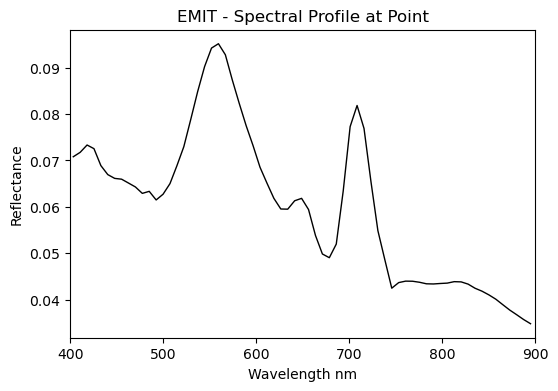

In [176]:
import numpy as np

# values: ee.List of spectral values (from previous step)
# emit_wavel: ee.List of wavelengths (same length as values)

# Get server-side lists to client
vals = np.array(values.getInfo(), dtype=float)
wavs = np.array(emit_wavel.getInfo(), dtype=float)

# Optional: restrict wavelength range, e.g. 400–900 nm
mask = (wavs >= 400) & (wavs <= 900)
wavs_plot = wavs[mask]
vals_plot = vals[mask]

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(wavs_plot, vals_plot, color='black', linewidth=1)
ax.set_title('EMIT - Spectral Profile at Point')
ax.set_xlabel('Wavelength nm')
ax.set_ylabel('Reflectance')
ax.set_xlim(400, 900)   # viewWindow min/max
ax.grid(False)

plt.show()
